In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from utils import *

In [17]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle  + h(X) \\ 
\text{subject to} & X = \mathcal{A}(Z)
\end{array} 
$$



## PDHG
$$
\begin{align*}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho \mathcal{A}(2Z^t - Z^{t-1}))\\
Z^{t+1} &=  \operatorname{prox}_{\gamma q }(Z^t - \gamma \mathcal{A}^*(Y^{t+1}))
\end{align*}
$$


In [18]:
std1 = 1
std2 = 1 
rank_ratio = 0.5
beta = 0.5 

In [19]:
n_head = 2

## `cvxpy` vs PDHG

In [20]:
for (m, n) in [(30, 15), (15, 30)]:
    for _ in range(1):
        A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True, dtype=torch.float64)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
        Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

        Grad_np = Grad.cpu().numpy()
        Z_star, f_star, Y_star = cvxpy_A_linop_heads(Grad_np, A_linop, beta, n_head=n_head)
        Z_star_torch = torch.from_numpy(Z_star).to(Grad.device)
        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A_linop=A_linop, Grad=Grad,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0,
            stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

        assert np.allclose((Z_star * Grad_np).sum(), torch.trace(Z_t.T @ Grad).item(),
            atol=1e-3, rtol=1e-3, )
        assert torch.max(torch.abs(A_linop.matvec(Z_t))).item() <= beta + 1e-2 \
           and torch.max(torch.abs(A_linop.matvec(Z_star_torch))).item() <= beta + 1e-3
print("PASSED")

PASSED


In [21]:
(Z_star * Grad_np).sum(), torch.trace(Z_t.T @ Grad).item(), f_star

(np.float64(-23.849969161226287),
 -23.849968800582005,
 np.float64(-23.849969161226287))

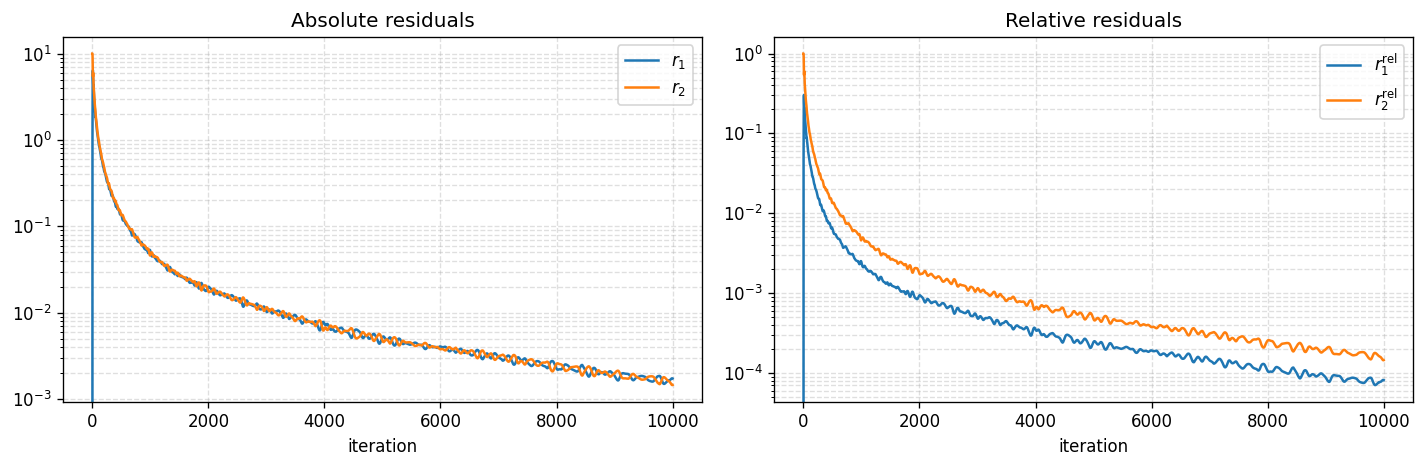

In [22]:
plot_residuals(residuals)

## Dual feasibility checks

In [23]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(1):
        A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

        A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
        Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

        Y0, res_lsmr, itn = solve_lsmr_Y_lstsq(A_linop, Grad, n_head=n_head)
        print(f"LSMR iters: {itn}, residual: {res_lsmr}")

30x60
LSMR iters: 50, residual: 3.701397190525313e-06
60x30
LSMR iters: 30, residual: 2.0150050659140106e-06
60x60
LSMR iters: 410, residual: 2.5659821403678507e-05


## Warm start

In [27]:
for (m, n) in [(500, 500)]: 
    A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

    A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
    Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

    Y0, res_lsmr, itn = solve_lsmr_Y_lstsq(A_linop, Grad, n_head=n_head) 
    print(f"{res_lsmr=}")
    Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0, n_head=n_head)

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
    Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A_linop=A_linop, Grad=Grad,
        max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0, #Y0=Y0, Z0=Z0,
        stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
        diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)


res_lsmr=tensor(3.0419e-05, device='cuda:0')


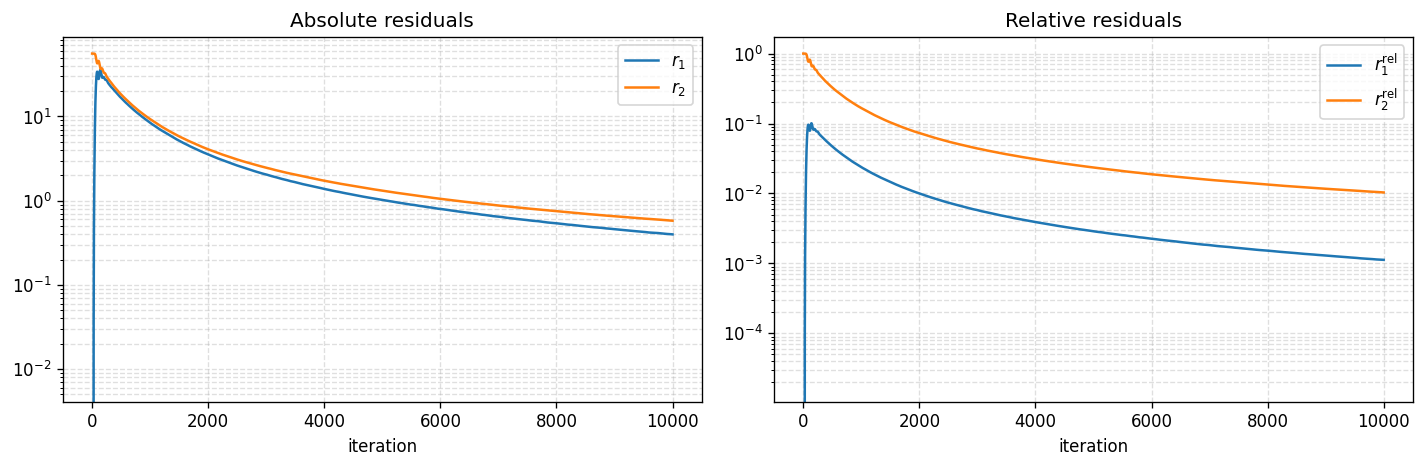

In [28]:
plot_residuals(residuals)

In [26]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(1.9999747086824318,
 0.997435774831647,
 0.013016338677689301,
 3.0398810643622344e-05)

## reHPDHG


In [12]:
for (m, n) in [(20, 40), (40, 20), (20, 20)]:
    for _ in range(1):
        A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                            rank_ratio=rank_ratio, G_in_range=True, dtype=torch.float64)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
        Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

        Grad_np = Grad.cpu().numpy()
        Z_star, f_star, Y_star = cvxpy_A_linop_heads(Grad_np, A_linop, beta, n_head=n_head)
        Y_star_torch = torch.from_numpy(Y_star).to(Grad.device)
        Z_star_torch = torch.from_numpy(Z_star).to(Grad.device)
        # Run torch PDHG
        print(pd_residuals_max_ball_linop(A_linop, Y_star_torch, Z_star_torch, Grad, beta, mu=0))

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A_linop=A_linop, Grad=Grad,
            max_iter=7000, eps_abs=1e-8, eps_rel=1e-8,
            h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
            diag_scaling=False, equilibration=False, reflected_halpern=True, enable_restart=True)

        print(pd_residuals_max_ball_linop(A_linop, Y_t, Z_t, Grad, beta, mu=0))

        assert np.allclose((Z_star * Grad_np).sum(), torch.trace(Z_t.T @ Grad).item(),
            atol=1e-3, rtol=5e-3)
        assert torch.max(torch.abs(A_linop.matvec(Z_t))).item() <= beta + 1e-2 \
           and torch.max(torch.abs(A_linop.matvec(Z_star_torch))).item() <= beta + 1e-3
print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(0.002331004856517471, 8.241346705111394e-05, 4.0048992323881054e-15, 3.573014296018096e-16)
(0.0020779488101995633, 7.346658473253147e-05, 0.0026448946108816505, 0.00023596714193745673)
(2.6571812539563736e-05, 1.8789108835143253e-06, 3.682516234916297e-15, 2.4447970129595715e-16)
(5.224918443642884e-08, 3.694575262646545e-09, 0.0034835662176238343, 0.00023127154749630598)
(1.281408741944226e-07, 9.06092810900485e-09, 6.997553497591534e-14, 6.518521354616186e-15)
(0.00010248052661833406, 7.24646753113925e-06, 0.01984391860187723, 0.001848546169888143)
PASSED


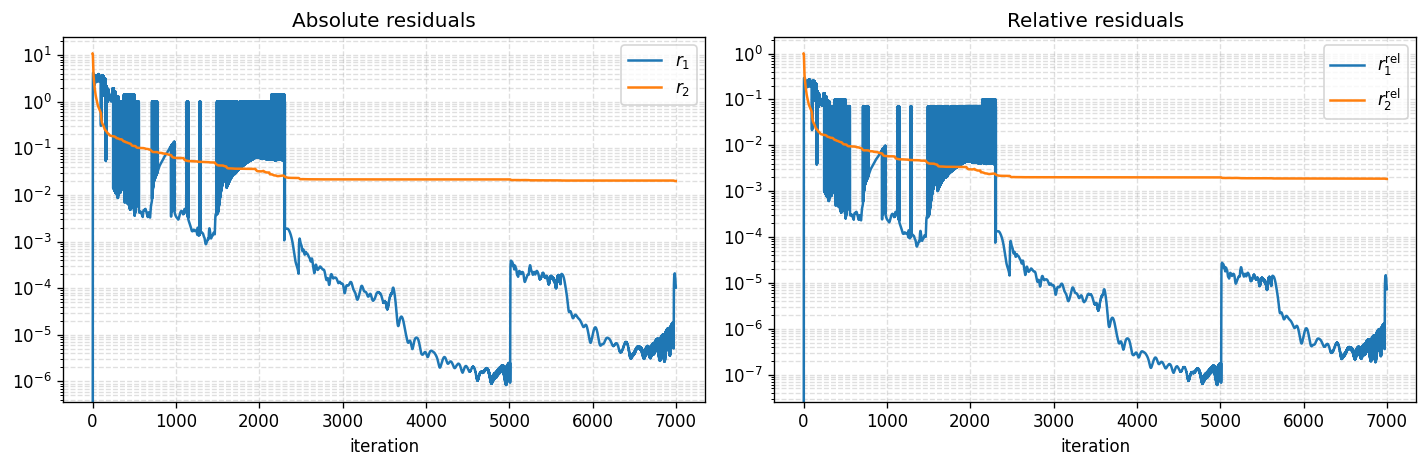

In [13]:
plot_residuals(residuals)

In [14]:
all_res = {}

settings = {"vanilla": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "diag_scaling": {"diag_scaling": True, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            # "equilibration": {"diag_scaling": False, "equilibration": True, "reflected_halpern":False, "enable_restart": False},
            "repdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": False},
            "ada_rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
            "ada_rehpdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
           }
m = n = 500
beta = 0.5 
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

for setting in settings:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
    Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A_linop=A_linop, Grad=Grad,
        max_iter=10**4, eps_abs=1e-8, eps_rel=1e-8,
        stopping=False, 
        h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball_linop,
        diag_scaling=settings[setting]["diag_scaling"], 
        equilibration=settings[setting]["equilibration"],
        reflected_halpern=settings[setting]["reflected_halpern"],
        enable_restart=settings[setting]["enable_restart"],
        verbose=True
    )
    all_res[setting] = residuals

    print(pd_residuals_max_ball_linop(A_linop, Y_t, Z_t, Grad, beta, mu=0))


||A||_op <= 7.0782e+02
(0.399443119764328, 0.0011297957547346663, 0.5833982825279236, 0.010406172745232471)
||A||_op <= 7.0782e+02
(0.399443119764328, 0.0011297957547346663, 0.5833982825279236, 0.010406172745232471)
||A||_op <= 7.0782e+02
(0.31162816286087036, 0.000881417548670509, 0.32380473613739014, 0.005775759238387578)
||A||_op <= 7.0782e+02
(36.14060592651367, 0.10222107010731418, 0.4379426836967468, 0.007811656899831415)
||A||_op <= 7.0782e+02
[RESTART] iter= 100 primal_weight=1.6191e-01 r_prim=3.642e-02 r_dual=6.413e-01
[RESTART] iter= 157 primal_weight=8.7620e-01 r_prim=4.194e-02 r_dual=5.060e-01
[RESTART] iter= 246 primal_weight=3.3199e-01 r_prim=4.531e-02 r_dual=3.220e-01
[RESTART] iter= 385 primal_weight=3.1142e-01 r_prim=4.547e-02 r_dual=2.319e-01
[RESTART] iter= 602 primal_weight=2.1740e-01 r_prim=5.515e-02 r_dual=1.673e-01
[RESTART] iter= 941 primal_weight=1.8037e-01 r_prim=6.069e-02 r_dual=1.224e-01
[RESTART] iter=1471 primal_weight=1.3896e-01 r_prim=6.619e-02 r_dual=8.

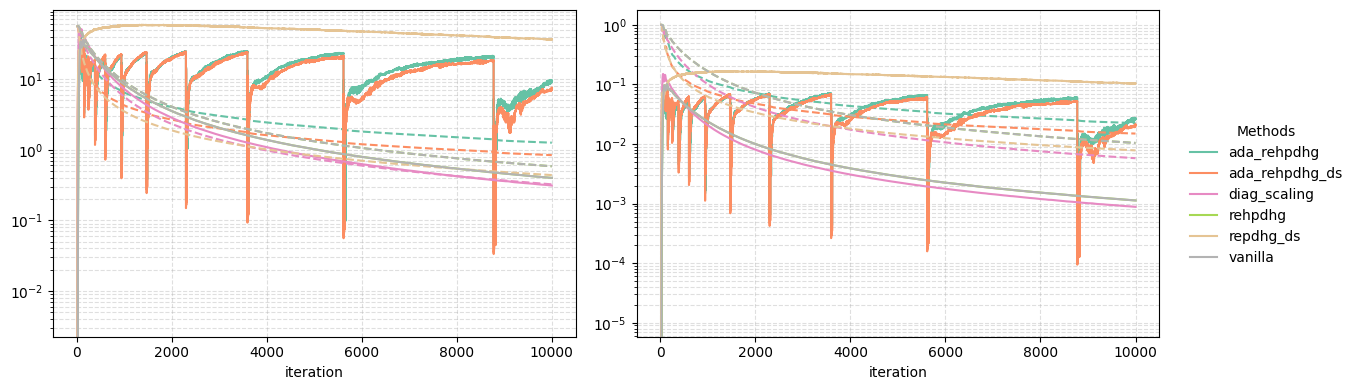

In [15]:
plot_residuals_compare(all_res, dpi=100, dual_scale=True)